In [4]:
#Required packages:
#PyPolyaGamma
!pip install PyPolyaGamma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyPolyaGamma: filename=pypolyagamma-1.2.3-cp310-cp310-linux_x86_64.whl size=778493 sha256=df070d1ed43edc360af1c9d4f30d3ace2bde555b00c5a9b7e1438bde70f6b3aa
  Stored in directory: /root/.cache/pip/wheels/56/83/bd/0378099f2c88026b81d825c119a47b94f100f1e748b2be04fa
Successfully built PyPolyaGamma


In [5]:
#Standard packages:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
from math import *
import numpy as np
import numpy.random as rd
import scipy.stats as stat
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal
from pypolyagamma import logistic, PyPolyaGamma

#Figure configuration:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# EXAMPLE 1: Bayesian logistic regression


Bayesian logistic regression model is a Bayesian version of the popular logistic regression model. We assume a Gaussian prior on regression coefficients.
Then, the working model is
\begin{align*}
Y(i) \mid X(i) \,,\, \beta &\sim
\mathrm{Bernoulli}(\sigma(X(i)\beta) )\,\, (i=1,\ldots,n),
\\
\beta &\sim \mathrm{Normal}(0,I),
\end{align*}
where $\sigma(x)=1/\{1+\exp(-x)\}$.

We compare
- Posterior mean of $\beta$
- Logistic ridge regression
\begin{align*}
\textrm{argmax}_{\beta} \left\{\sum_{i=1}^{n} l(y(i),x(i)\,;\,\beta)  - \frac{\|\beta\|^{2}}{2}\right\}
\end{align*}
with $l(y(i),x(i)\,;\,\beta):=y(i)\log \sigma(x(i)\beta)+(1-y(i))\log \{1-\sigma(x(i)\beta)\}$.
- MAP estimate of $\beta$ using matching prior pair of Gaussian prior
\begin{align*}
\textrm{argmax}_{\beta} \left\{\sum_{i=1}^{n} l(y(i),x(i)\,;\,\beta)  - \frac{1}{2}\|\beta\|^{2} - \frac{1}{2}\log \left| \sum_{i=1}^{n}(X(i))^{\top}X(i)\left[\sigma(X(i)\beta)\{1-\sigma(X(i)\beta)\}\right] \right|\right\}.
\end{align*}


The comparison utilizes the banknote authentication data
from UCI Machine Learning Repository.

In [20]:
#Conducting MCMC using Polya-Gamma augumentation
def baylogit(Xs,Ys,pos_samples = 20000,thinning    = 10,burnin      = 10000, beta_sigma2=1):
  #Input:
      #Xs: Xs in logistic regression
      #Ys: Ys in logistic regression
      #pos_samples: number of posterior samples
      #thinning: set-up of thinning
      #burinin: set-up of burinin period
      #beta_sigma2: set-up of prior variance
  #Output:
      #Posterior samples of beta
    pg = PyPolyaGamma(seed=0)
    n   = Ys.shape[0]
    dim = Xs.shape[1]
    omegas = np.ones((n,pos_samples))
    betas = np.ones((dim, pos_samples))
    for i in range(1, pos_samples):
        omegas[:,i] = [pg.pgdraw(1, Xs[s,:].dot(betas[:,i-1])) for s in range(n)]
        V_omega = np.linalg.inv( Xs.T @ np.diag(omegas[:,i]) @ Xs+ (1/beta_sigma2)*np.eye(dim) )
        mu_omega = V_omega @ (Xs.T @ (Ys-1/2))
        betas[:,i] = multivariate_normal.rvs(
        mean=mu_omega[:],
        cov=V_omega,
        size=1)
    final_betas = betas[:,range(burnin,pos_samples,thinning)]
    return final_betas

#Sigmoid function
def sigmoid(x):
 return 1/(1 + np.exp(-x))


#Conducting logistic ridge regression
def calc_penalizedlogistic(Ys,Xs,init):
  #Input:
      #Xs: Xs in logistic regression
      #Ys: Ys in logistic regression
      #init: initial values for optimization
  #Output:
      #logistic ridge regression estimate
  def minusobs(beta):
    dim = Xs.shape[1]
    n   = Ys.shape[0]
    loglikelihood_vec = np.array([ Ys[i]*np.log( sigmoid(Xs[i,:].dot(beta)) ) + (1-Ys[i])*np.log(1-sigmoid(Xs[i,:].dot(beta))) for i in range(n)])
    logprior_vec      = np.array([ (-1)*np.sum(beta**2)/(2*n) for i in range(n)])
    return (-1)*(np.sum(loglikelihood_vec)+np.sum(logprior_vec))
  dim=len(init)
  MAP = opt.minimize(fun=minusobs,x0=init)
  return MAP.x


#Conducting MAP using mathcing prior pair of Gaussian prior
def calc_modifiedpenalizedlogistic(Ys,Xs,init):
  #Input:
      #Xs: Xs in logistic regression
      #Ys: Ys in logistic regression
      #init: initial values for optimization
  #Output:
      #MAP using mathcing prior pair of Gaussian prior
  def minusobs(beta):
    dim = Xs.shape[1]
    n   = Ys.shape[0]
    loglikelihood_vec = np.array([ Ys[i]*np.log( sigmoid(Xs[i,:].dot(beta)) ) + (1-Ys[i])*np.log(1-sigmoid(Xs[i,:].dot(beta))) for i in range(n)])
    logGauss_vec      = np.array([ (-1)*np.sum(beta**2)/(2*n) for i in range(n)])
    Fisher_vec        = np.array([ np.matmul(Xs[i,:].reshape((1,dim)).T, Xs[i,:].reshape((1,dim))) * sigmoid(Xs[i,:].dot(beta))*(1-sigmoid(Xs[i,:].dot(beta))) for i in range(n)])
    return (-1)*(np.sum(loglikelihood_vec)+np.sum(logGauss_vec)-(1/2)*np.linalg.slogdet(np.mean(Fisher_vec,axis=0))[1])
  dim=len(init)
  MAP = opt.minimize(fun=minusobs,x0=init)
  return MAP.x

In [25]:
#Preparation for data
df_banknote = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt",header=None)
df_banknote.columns = ["Variance","Skewness","Curtosis","Entropy","Class"]
n_max_bank=df_banknote.shape[0]

Ys_bank=df_banknote["Class"].to_numpy()
Xs_bank=df_banknote[["Variance","Skewness","Curtosis","Entropy"]].to_numpy()

#MCMC, logistic ridge regression, MAP using mathcing prior pair of Gaussian prior
pos_bank=baylogit(Xs=Xs_bank,Ys=Ys_bank,pos_samples = 20000,thinning    = 1,burnin      = 10000, beta_sigma2=1)

MAP_bank=calc_penalizedlogistic(Ys=Ys_bank,Xs=Xs_bank,init=np.zeros(4))
modifMAP_bank=calc_modifiedpenalizedlogistic(Ys=Ys_bank,Xs=Xs_bank,init=MAP_bank)

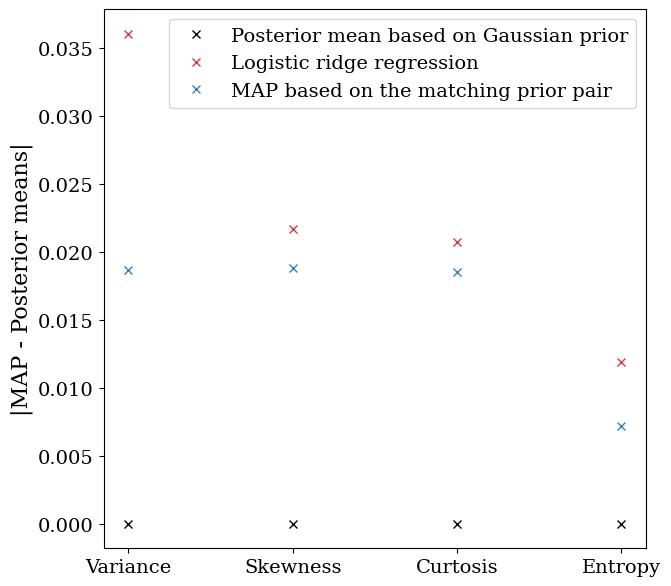

In [36]:
#Display estimates
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
ax.plot([0,1,2,3],abs(pos_bank.mean(axis=1)-pos_bank.mean(axis=1)),"x",color="black",label="Posterior mean based on Gaussian prior")
ax.plot([0,1,2,3],abs(MAP_bank-pos_bank.mean(axis=1)),"x",color="tab:red",alpha=0.9,label="Logistic ridge regression")
ax.plot([0,1,2,3],abs(modifMAP_bank-pos_bank.mean(axis=1)),"x",color="tab:blue",alpha=0.9,label="MAP based on the matching prior pair")
ax.legend(loc="upper right",prop={'size':14})
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["Variance","Skewness","Curtosis","Entropy"],fontsize=16)
ax.set_ylabel("|MAP - Posterior means|",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# EXAMPLE 2: Poisson shrinkage models

Poisson sequence model is a gold-standard starting point of count-data analysis.
Here we investigate the calibration in high-dimension based on the matching prior pair of the improper shrinkage prior proposed by Komaki (2006):
\begin{align*}
Y(i) =(Y_{1}(i),\ldots, Y_{d}(i))\mid \lambda=(\lambda_{1},\ldots,\lambda_{d}) &\sim \otimes_{i=1}^{d} \mathrm{Poisson}(\lambda_{i}) \,\, (i=1,\ldots,n),\\
\pi(\lambda)&= \frac{\lambda_{1}^{\beta_{1}-1}\cdots\lambda_{d}^{\beta_{d}-1}}{(\lambda_{1}+\cdots+\lambda_{d})^{\alpha}},
\end{align*}


Sampling from Komaki's shrinkage prior for Poisson models is as follows:

*   Model:
$X_{i} \sim Po(r \lambda_i ),\,i=1,\ldots,d$ where $r$ is the sample size.


*   Prior:
$\pi_{\alpha,\beta}(\lambda)=\frac{\lambda_{1}^{\beta_{1}-1}\cdots\lambda_{d}^{\beta_{d}-1}}{(\lambda_{1}+\cdots+\lambda_{d})^\alpha}$

*  Posterior:
$\pi_{\alpha,\beta}(\lambda \mid x)\propto \left\{\prod_{i=1}^{d} \left(\frac{\lambda_{i}}{\|\lambda\|_{1}}\right)^{x_{i}+\beta_{i}-1}\right\} \left\{\|\lambda\|_{1}^{\sum_{i}(x_{i}+\beta_{i}-1)-\alpha}e^{-r\|\lambda\|_{1}}
\right\}$

* Change of variables $(\lambda_{1},\ldots,\lambda_{d}) \to (w_{1}=\lambda_{1}/\|\lambda\|_{1},\ldots,w_{d}=\lambda_{d}/\|\lambda\|_{1}, \mu=\|\lambda\|_{1})$

> * Jacobian: $\mu^{d-1}dw_{1}\ldots d w_{d-1}d\mu=d\lambda_{1}\ldots d\lambda_{d}$

> * Posterior: $\pi_{\alpha,\beta}(w,\mu \mid x)\propto \left\{\prod_{i=1}^{d} w_{i}^{x_{i}+\beta_{i}-1}\right\} \left\{\mu^{\sum_{i}(x_{i}+\beta_{i})-d-\alpha}e^{-r\mu}
\right\}\mu^{d-1} = \left\{\prod_{i=1}^{d} w_{i}^{x_{i}+\beta_{i}-1}\right\} \left\{\mu^{\sum_{i}(x_{i}+\beta_{i})-\alpha-1}e^{-r\mu}
\right\}$

*  Exact sampling from the posterior:

  1. First sample $\mu:=\|\lambda\|_{1}$ from $\mathrm{Gamma}(\mathrm{shape}=\sum(x_{i}+\beta_{i})-\alpha,\,\mathrm{scale}=1/r)$
  2. Then sample $(w_1,\ldots,w_d)$ from $\mathrm{Dirichlet}(x_1 + \beta_1 ,\ldots,x_d+\beta_d)$
  3. Output $\lambda_1=w_1 \mu,\ldots,\lambda_d=w_d \mu$


In this example, we employ synthetic data to compare MAP estimate based on Komaki's improper prior; posterior mean of the same prior; and posterior mean based on the matching prior pair.

In [29]:

#Calculating MAP estimate with hyperparameter beta and alpha

def calc_MAP(X,init,hyperparam_beta,hyperparam_alpha):
  #Input:
      #X: observations (n times d)
      #beta: dim-dimensional array
      #alpha: scalar
      #init: initial value for optimization
  #Output:
      #MAP estimate
  def minus_log_pos(lam):
    dim = len(lam)
    r  = X.shape[0]
    loglikelihood_vec = np.array([X.sum(axis=0)[i]*np.log(lam[i])-r*lam[i] for i in range(dim)])
    logprior_vec      = np.array([ (hyperparam_beta[i]-1)* np.log(lam[i]) - (hyperparam_alpha/dim)*np.log(sum(lam)) for i in range(dim)])
    return (-1)*(sum(loglikelihood_vec)+sum(logprior_vec))
  dim=len(init)
  MAP = opt.minimize(minus_log_pos,init,bounds = tuple([(0.0001,np.inf) for i in range(dim)]))
  return MAP.x


#Conducting MCMC with hyperparameter beta and alpha

def possample_K04(X,hyperparam_beta,hyperparam_alpha,pos_num):
  #Input:
      #X: observations (n times d)
      #beta: dim-dimensional array
      #alpha: scalar
      #init: initial value for optimization
      #pos_num: int. for num of posterior samples
  #Output:
      #(posterior samples of mu, posterior samples of w, posterior samples of lambda)
  dim = X.shape[1]
  r   = X.shape[0]
  shape = X.sum()+hyperparam_beta.sum()-hyperparam_alpha
  scale = 1/r
  pos_lam_length = np.random.gamma(shape=shape,scale=scale,size=pos_num)
  alpha = X.sum(axis=0)+hyperparam_beta
  pos_w          = np.random.dirichlet(alpha=alpha,size=pos_num)
  return pos_lam_length, pos_w , np.array([ pos_lam_length[i]* pos_w[i] for i in range(pos_num)])

In [30]:
#======================================================================
# Create synthetic data
# X's shape (N, dim)
dim =  100
N   =   10
pos_sample=10000
lam_true = np.array([0.001 if (i % 2 == 0) else 2 for i in range(dim)])
X = np.array([np.random.poisson(lam=lam_true) for n in range(N)])


#======================================================================
# Matching prior pair construction

hyperparam_beta  = 3*np.ones(dim)
hyperparam_alpha = sum(hyperparam_beta)-1

adjusted_beta  = hyperparam_beta-1.
adjusted_alpha = hyperparam_alpha

#======================================================================
# adust means posterior samples based on the matching prior pair
# nonadust means posterior samples based on the initial prior

MAP=calc_MAP(X,lam_true,hyperparam_beta,hyperparam_alpha)
pos_lam_adjust=possample_K04(X=X,hyperparam_beta=adjusted_beta ,hyperparam_alpha=adjusted_alpha,pos_num=pos_sample)[2]
pos_lam_nonadjust=possample_K04(X=X,hyperparam_beta=hyperparam_beta,hyperparam_alpha=hyperparam_alpha,pos_num=pos_sample)[2]

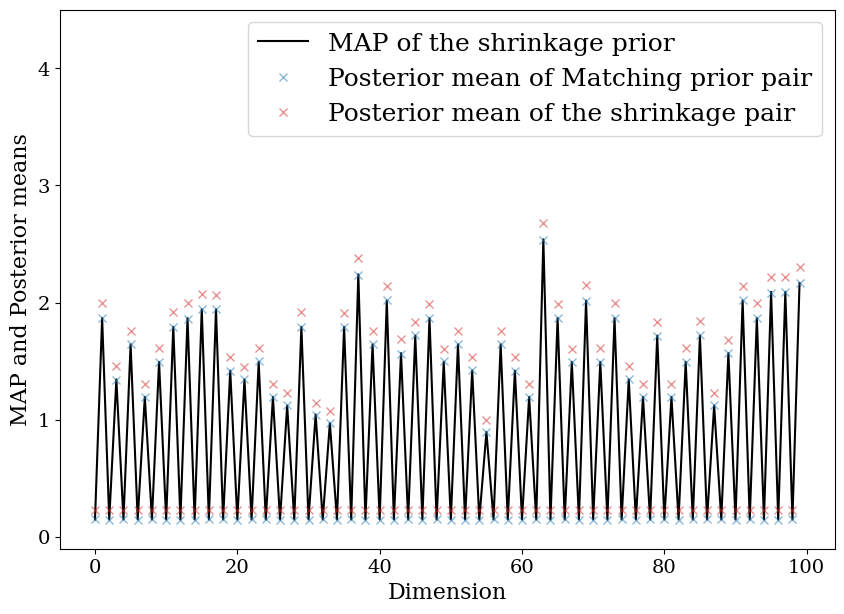

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.subplots_adjust(wspace=0.2, hspace=0.4)


ax.plot(MAP,color="black",label="MAP of the shrinkage prior")
ax.plot(pos_lam_adjust.mean(axis=0),"x",color="tab:blue",alpha=0.5,label="Posterior mean of Matching prior pair")
ax.plot(pos_lam_nonadjust.mean(axis=0),"x",color="tab:red",alpha=0.5,label="Posterior mean of the shrinkage pair")
ax.set_ylim(-0.1,4.5)
ax.legend(loc="upper right",prop={'size':18})
ax.set_ylabel("MAP and Posterior means",fontsize=16)
ax.set_xlabel("Dimension",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)

# On calibration formula (Corollary 2.2)

The following is our Corollary 2.2:
For a prior $\pi$,
the posterior expectation $\hat{\theta}_{\rm{PM}}$ is calculated by
\begin{equation*}
\hat{\theta}_{\rm{PM}}^{a} =
\hat{\theta}_{\rm{MAP}}^{a} + \frac{1}{2n}g^{ab}(\hat{\theta}_{\rm{MAP}})g^{cd}(\hat{\theta}_{\rm{MAP}})
\left\{\frac{1}{n}
\sum_{t=1}^{n}\partial_{bcd}\log p(y(t)\,;\,\hat{\theta}_{\rm{MAP}})
\right\}
+o_{p}(n^{-1})
\end{equation*}
for $a=1,\ldots,d$.

This formula is derived from several ingredients of the proof of the main theorem (Theorem 2.1 in the main manuscript; see also Section 4). It can also be obtained through the asymptotic expansion in Miyata (2004) (see also Yanagimoto and Miyata, 2023); however, it has not been used for our specific purpose, that is, calibrating the posterior expectation and the MAP. In practice, the higher-order derivatives in the formula can be efficiently computed using automatic differentiation (cf. Iri, 1984 and  Baydin et al., 2018).


To check the validity of this formula, we employ the following $d$-variate Cauchy model with a Gaussian prior:
\begin{equation*}
    Y(t) \mid \mu \sim \text{MultivariateCauchy}(\mu,I)\quad (t=1,\ldots,n),\quad \mu \sim \text{Normal}(0,100 I),
\end{equation*}
where the $d$-variate Cauchy density with location $\mu$ and scale matrix $I$ is given by
\[
p(y \,;\, \mu, I)
=\frac{1}{\pi^{d}}\frac{\Gamma((d+1)/2)}{\Gamma(1/2)}\frac{1}{(1+\|y-\mu\|^{2})^{(d+1)/2}}
\]
with the Gamma function $\Gamma(k)$.
The tail-heaviness slows down the convergence of MCMC algorithms especially in high dimension (c.f., Douc et al., 2004 and Kamatani, 2020);
in such a case,
the calibration of the posterior mean from the MAP estimate can offer an anchor of the convergence. We employ the random-walk Metropolis--Hastings algorithms based on the multivariate Cauchy distribution with the step size determined by $0.1/\sqrt{d}$.

In [11]:
import autograd.numpy as np
from autograd import grad, hessian, jacobian
from scipy.stats import multivariate_normal

In [12]:
# Log-likelihood function for the multivariate Cauchy model
def log_likelihood(mu, X):
    n, d = X.shape
    diff = X - mu
    return -n * d * np.log(np.pi) - 0.5 * (d + 1) * np.sum(np.log(1 + np.sum(diff**2, axis=1)))

# First-order derivative (gradient)
grad_log_likelihood = grad(log_likelihood, 0)

# Second-order derivative (Hessian)
hessian_log_likelihood = hessian(log_likelihood, 0)

# Third-order derivative tensor
third_derivative = jacobian(hessian_log_likelihood, 0)

# Log of the prior distribution (assuming a normal distribution)
def log_prior(mu, mean_prior=0, var_prior=100):
    return -0.5 * np.sum((mu - mean_prior)**2 / var_prior)

# Log-posterior distribution combining the likelihood and prior
def log_posterior(mu, X, mean_prior=0, var_prior=100):
    return log_likelihood(mu, X) + log_prior(mu, mean_prior, var_prior)

def neg_log_posterior(mu, X, mean_prior=0, var_prior=100):
    return -log_posterior(mu, X, mean_prior, var_prior)

def neg_log_likelihood(mu, X):
    return -log_likelihood(mu, X)

# Generate samples from a multivariate Cauchy distribution
def multivariate_cauchy_sample(n, d, mu=None, scale=None):
    """
    Generates samples from a multivariate Cauchy distribution.
    - n: Number of samples
    - d: Number of dimensions
    - mu: Location vector (default is zero vector)
    - scale: Scale matrix (default is identity matrix)
    """
    if mu is None:
        mu = np.zeros(d)
    if scale is None:
        scale = np.eye(d)

    # Sampling as a special case of the multivariate t-distribution with 1 degree of freedom (Cauchy distribution)
    z = np.random.standard_normal(size=(n, d))  # Sample from standard normal distribution
    w = np.random.standard_normal(size=(n, 1))  # Scalar part

    x = mu + np.dot(z, np.linalg.cholesky(scale).T) / np.abs(w)  # Multivariate Cauchy samples
    return x

# Metropolis-Hastings algorithm
def metropolis_hastings(X, initial_mu, num_samples=1000, proposal_std=0.5, burn_in=200, mean_prior=0, var_prior=100):
    d = initial_mu.shape[0]
    mu_current = initial_mu
    samples = []

    # Initial posterior probability
    log_post_current = log_posterior(mu_current, X, mean_prior, var_prior)

    for i in range(num_samples + burn_in):
        # Generate a new sample from the proposal distribution (using normal distribution)
        mu_proposal = mu_current + proposal_std * multivariate_cauchy_sample(1, d)[0]

        # Log-posterior at the proposed point
        log_post_proposal = log_posterior(mu_proposal, X, mean_prior, var_prior)

        # Calculate acceptance ratio
        acceptance_ratio = np.exp(log_post_proposal - log_post_current)

        # Decide whether to accept the proposal
        if np.random.rand() < acceptance_ratio:
            mu_current = mu_proposal
            log_post_current = log_post_proposal

        # Save the sample after the burn-in period
        if i >= burn_in:
            samples.append(mu_current)

    return np.array(samples)

# Compute tensor contraction
def compute_tensor_contraction(G, T):
    """
    Computes the tensor contraction.
    - G: Inverse of the Hessian matrix (d, d)
    - T: Third-order derivative tensor (d, d, d)
    """
    return np.einsum('ij,kl,jkl->i', G, G, T)


In [13]:
from scipy.optimize import minimize

# Set parameters
n = 10  # Sample size
d = 10  # Number of dimensions
true_mu = 10 * np.ones(d)

# Generate samples from a multivariate Cauchy distribution
X = multivariate_cauchy_sample(n, d, mu=true_mu)

# Initial values for Metropolis-Hastings sampling
initial_mu = np.zeros(d)

# Run Metropolis-Hastings algorithm
samples = metropolis_hastings(X, initial_mu, num_samples=100000, proposal_std=0.1 / np.sqrt(d), burn_in=50000)
posterior_mean_Cauchy = np.mean(samples, axis=0)

# Initial guess for optimization
initial_guess = np.median(X, axis=0)

# Calculate MAP estimate using the posterior
MAP_Cauchy = minimize(neg_log_posterior, initial_guess, args=(X,)).x

# Calculate MLE using the likelihood
MLE_Cauchy = minimize(neg_log_likelihood, initial_guess, args=(X,)).x

# Compute gradient, Hessian, and third derivative tensor at the MLE
mu = MLE_Cauchy
gradient = grad_log_likelihood(mu, X)
hessian = hessian_log_likelihood(mu, X)
third_deriv_tensor = third_derivative(mu, X)

# Calculate the calibration term
H = -hessian / n
G = np.linalg.pinv(H)
T = third_deriv_tensor / n
calibration_result = compute_tensor_contraction(G, T) / (2 * n)

# Final results
A_samples = samples
A_MAP = MAP_Cauchy
A_calibrated = MAP_Cauchy + calibration_result


Text(0.5, 0, 'Dimension')

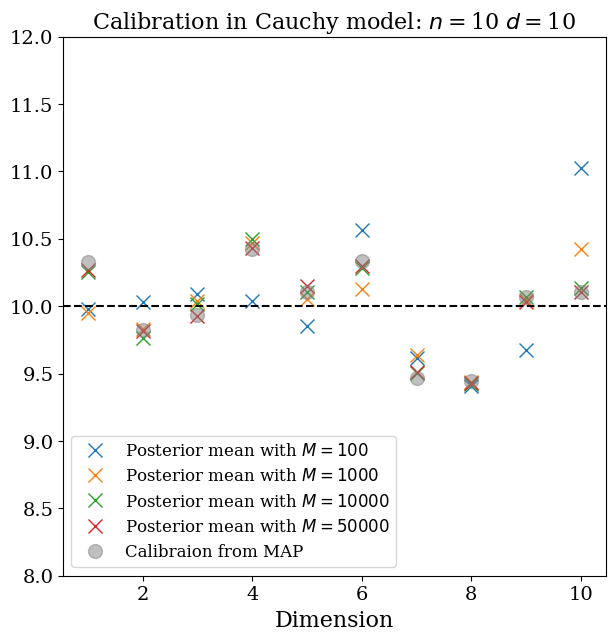

In [19]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ss = 10

ax.set_title("Calibration in Cauchy model: "+r"$n=$"+str(n)+" "+r"$d=$"+str(d),fontsize=16)
ax.plot(range(1,d+1), A_samples[0:100,:].mean(axis=0), "x",markersize=ss, label="Posterior mean with "+r"$M=100$")
ax.plot(range(1,d+1), A_samples[0:1000,:].mean(axis=0), "x", markersize=ss,label="Posterior mean with "+r"$M=1000$")
ax.plot(range(1,d+1), A_samples[0:10000,:].mean(axis=0), "x",markersize=ss, label="Posterior mean with "+r"$M=10000$")
ax.plot(range(1,d+1), A_samples[0:50000,:].mean(axis=0), "x",markersize=ss, label="Posterior mean with "+r"$M=50000$")
ax.plot(range(1,d+1), A_calibrated, "o", color="gray",markersize=ss,alpha=0.5,label="Calibraion from MAP")
ax.axhline(y=10, color="black", linestyle='--')
ax.set_ylim(-2.0+10, 2.0+10)
ax.legend(loc="lower left",fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("Dimension",fontsize=16)